In [3]:
%%capture
!pip install --upgrade openpmd-beamphysics pydantic

In [ ]:
os.chdir('..')

In [43]:
import requests
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pyvista as pv
import os
from pmd_beamphysics import ParticleGroup
import pydantic
from astra_generator.generator.schemas import Particles
from astra_generator.simulation.schemas import XYEmittanceTable, ZEmittanceTable

In [5]:
def to_pmd(particles: pd.DataFrame) -> ParticleGroup:
    data = particles.copy()
    ref = data.iloc[0]

    data['weight'] = np.abs(data.pop('macro_charge')) * 1e-9
    data.loc[1:, 'z'] = data.loc[1:, 'z'] + ref['z']
    data.loc[1:, 'pz'] = data.loc[1:, 'pz'] + ref['pz']
    data.loc[1:, 't_clock'] = (data.loc[1:, 't_clock'] + ref['t_clock'])*1e-9
    data.loc[data['status'] == 1, 'status'] = 2
    data.loc[data['status'] == 5, 'status'] = 1
    
    data_dict = data.to_dict('list')
    data_dict['n_particles'] = data.size
    data_dict['species'] = 'electron'
    data_dict['t'] = ref['t_clock']*1e-9

    return ParticleGroup(data=data_dict)

In [49]:
input_filepath = os.path.abspath("./tests/sample/input/out.ini")
output_filepath = os.path.abspath("./tests/sample/output/xfel.0320.001")
x_emit_path = os.path.abspath("./tests/sample/output/xfel.Xemit.001")
y_emit_path = os.path.abspath("./tests/sample/output/xfel.Yemit.001")
z_emit_path = os.path.abspath("./tests/sample/output/xfel.Zemit.001")

In [33]:
input_df = pd.read_fwf(input_filepath, names=list(Particles.model_fields.keys()))
input_particles = to_pmd(input_df)

In [37]:
output_df = pd.read_fwf(output_filepath, names=list(Particles.model_fields.keys()))
output_particles = to_pmd(output_df)

## Side views

### Input distribution

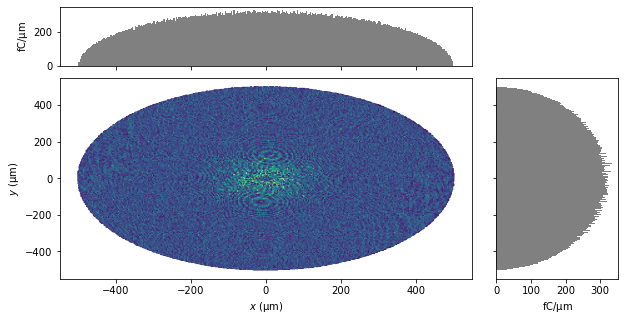

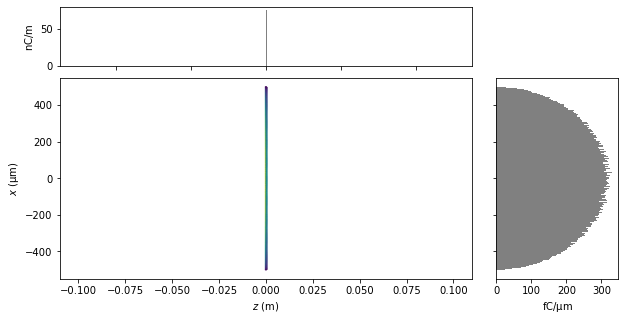

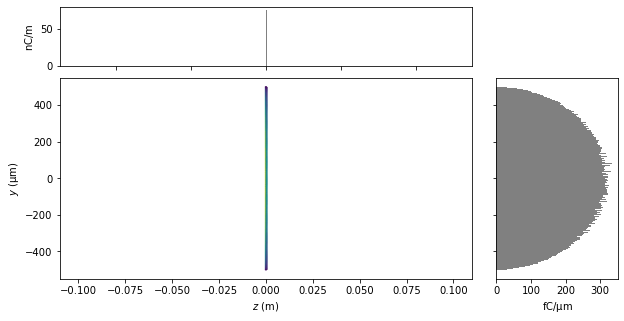

In [38]:
input_particles.plot('x', 'y', bins=300, figsize=(10, 5))
input_particles.plot('z', 'x', bins=300, figsize=(10, 5))
input_particles.plot('z', 'y', bins=300, figsize=(10, 5))

### Output distribution

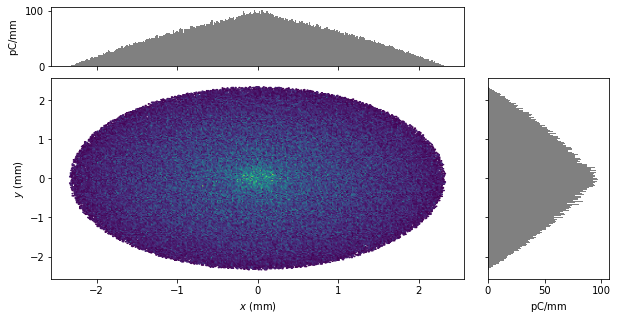

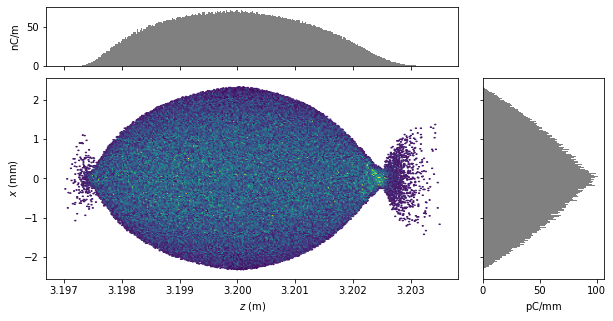

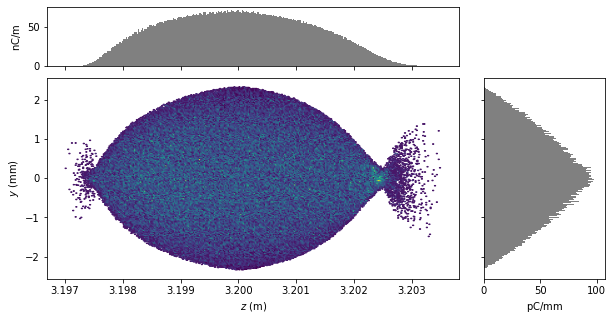

In [39]:
output_particles.plot('x', 'y', bins=300, figsize=(10, 5))
output_particles.plot('z', 'x', bins=300, figsize=(10, 5))
output_particles.plot('z', 'y', bins=300, figsize=(10, 5))

## Phase spaces

### Input distribution

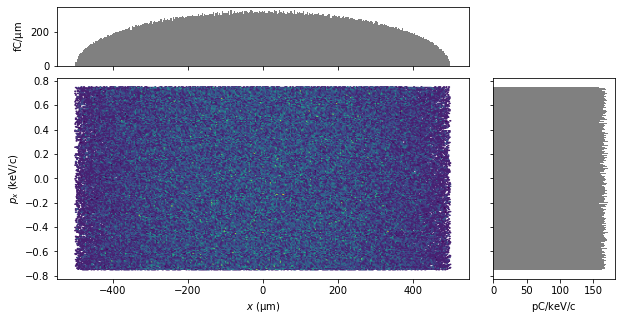

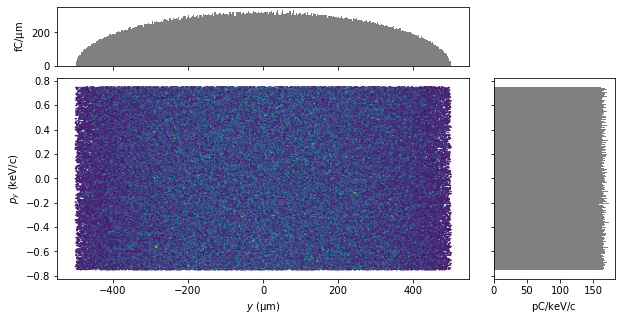

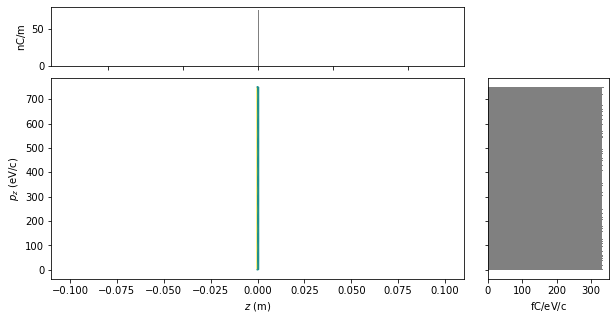

In [40]:
input_particles.plot('x', 'px', bins=300, figsize=(10, 5))
input_particles.plot('y', 'py', bins=300, figsize=(10, 5))
input_particles.plot('z', 'pz', bins=300, figsize=(10, 5))

### Output distribution

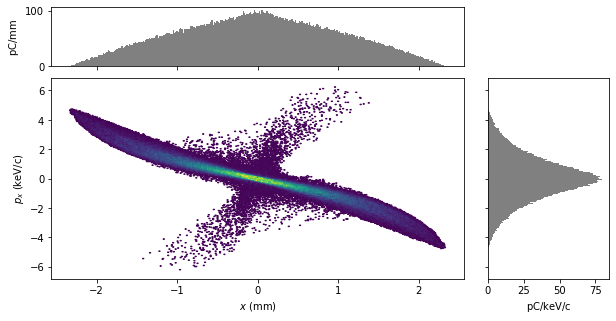

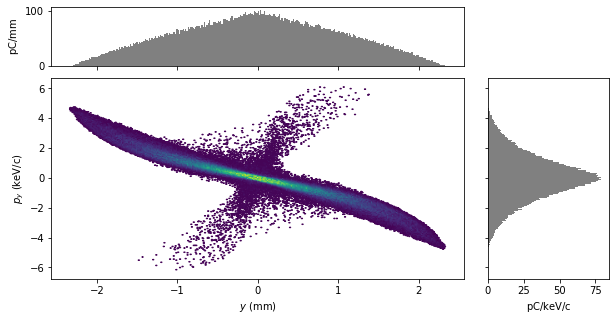

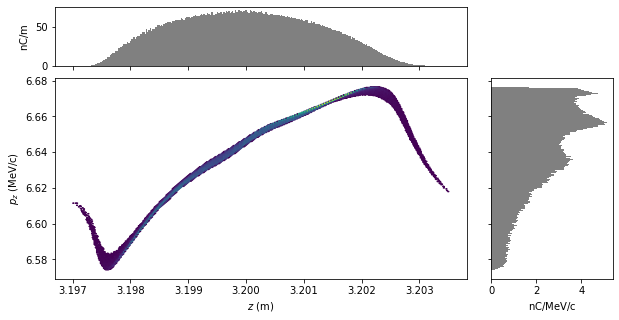

In [41]:
output_particles.plot('x', 'px', bins=300, figsize=(10, 5))
output_particles.plot('y', 'py', bins=300, figsize=(10, 5))
output_particles.plot('z', 'pz', bins=300, figsize=(10, 5))

## Emittance

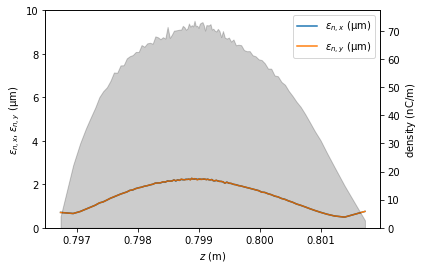

In [36]:
output_particles.slice_plot('norm_emit_x', 'norm_emit_y', ylim=(0, 1e-5))

<AxesSubplot:xlabel='z'>

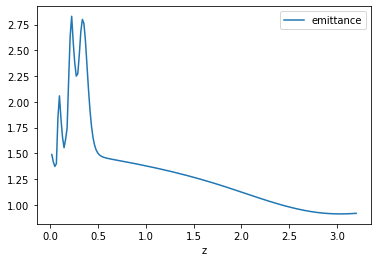

In [46]:
emit_x = pd.read_fwf(x_emit_path, names=list(XYEmittanceTable.model_fields.keys()))
emit_x.plot(x='z', y='emittance')

<AxesSubplot:xlabel='z'>

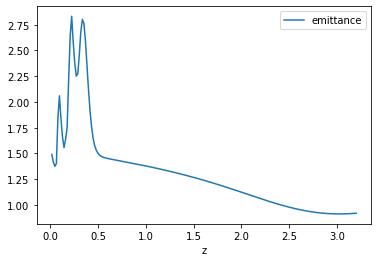

In [50]:
emit_y = pd.read_fwf(y_emit_path, names=list(XYEmittanceTable.model_fields.keys()))
emit_y.plot(x='z', y='emittance')

<AxesSubplot:xlabel='z'>

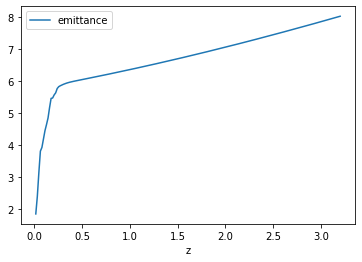

In [51]:
emit_z = pd.read_fwf(z_emit_path, names=list(ZEmittanceTable.model_fields.keys()))
emit_z.plot(x='z', y='emittance')